In [8]:
from transformers import BertTokenizer, BertModel, AlbertTokenizerFast, AlbertModel
import torch
import torch.nn.functional as F
import re
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Data loading + making equations

In [9]:
def get_equation(reaction,reaction_rate):
    neg, delim ,pos =re.split(r'(<->|->|<-)', reaction, maxsplit=1)
    all_terms = ["-" + term for term in neg.split("+")]
    all_terms.extend(pos.split("+"))
    all_terms.append(reaction_rate)
    equation = (" = ".join(all_terms)).replace(" null =","")
    return equation

In [10]:
data = pd.read_csv("/home/jovyan/work/dufourspitze_16/data/final_table.csv", index_col=0)
data['equations'] = data.apply(lambda row: get_equation(row['reaction'], row['reaction rate']), axis=1)
data['simplified_equations'] = data.apply(lambda row: get_equation(row['simplified_reaction'], row['simplified_reaction_rate']), axis=1)
data.to_csv("/home/jovyan/work/dufourspitze_16/data/final_table.csv")
data

,reaction,reaction rate,description,simplified_reaction,simplified_reaction_rate,equations,simplified_equations
reaction number,,,,,,,
1,[Blood-Lymph].CTLA4_mabB <-> Lymph_Node.CTLA4_mab,Kpa_LNB*S_LNB*VL*f_LN_CTLA4*([Blood-Lymph].CTL...,Distribution of Anti-CTLA-4 mAb between the ce...,alpha.CE <-> delta.CD,Kpa_LNB*S_LNB*VL*f_LN_CTLA4*(alpha.CE/Vc_CTLA4...,-[Blood-Lymph].CTLA4_mabB = Lymph_Node.CTLA4...,-alpha.CE = delta.CD = Kpa_LNB*S_LNB*VL*f_LN...
2,[Blood-Lymph].CTLA4_mabB <-> Peripheral.CTLA4_...,0.67*Q_L*[Blood-Lymph].CTLA4_mabB*(1-Sigma1_CT...,Distribution of Anti-CTLA-4 mAb between the ce...,alpha.CE <-> epsilon.CG,0.67*Q_L*alpha.CE*(1-Sigma1_CTLA4)/Vc_CTLA4 - ...,-[Blood-Lymph].CTLA4_mabB = Peripheral.CTLA4...,-alpha.CE = epsilon.CG = 0.67*Q_L*alpha.CE*(...
3,[Blood-Lymph].CTLA4_mabB <-> Peripheral.CTLA4_...,0.33*Q_L*[Blood-Lymph].CTLA4_mabB*(1-Sigma2_CT...,Distribution of Anti-CTLA-4 mAb between the ce...,alpha.CE <-> epsilon.CH,0.33*Q_L*alpha.CE*(1-Sigma2_CTLA4)/Vc_CTLA4- (...,-[Blood-Lymph].CTLA4_mabB = Peripheral.CTLA4...,-alpha.CE = epsilon.CH = 0.33*Q_L*alpha.CE*(...
4,[Blood-Lymph].CTLA4_mabB <-> Tumor.CTLA4_mabt,Kpa_TB*S_TB*Vt_avg_const*[Blood-Lymph].CTLA4_m...,Distribution of Anti-CTLA-4 mAb between the ce...,alpha.CE <-> zeta.CJ,Kpa_TB*S_TB*Vt_avg_const*alpha.CE/Vc_PD1-Kpa_T...,-[Blood-Lymph].CTLA4_mabB = Tumor.CTLA4_mabt...,-alpha.CE = zeta.CJ = Kpa_TB*S_TB*Vt_avg_con...
5,[Blood-Lymph].CTLA4_mabB -> null,Cl_CTLA4*[Blood-Lymph].CTLA4_mabB,Clearance of Anti-CTLA-4 mAb from the central ...,alpha.CE -> null,Cl_CTLA4*alpha.CE,-[Blood-Lymph].CTLA4_mabB = Cl_CTLA4*[Blood-...,-alpha.CE = Cl_CTLA4*alpha.CE
...,...,...,...,...,...,...,...
444,Tumor.PDL1_mabt + Tumor.[C3=PDL1] <-> Tumor.[C...,[kon_PDL1-PDL1mAb]*Tumor.PDL1_mabt*Tumor.[C3=P...,Interaction at the immunological synapse betwe...,zeta.GI + zeta.BE <-> zeta.BE:aPDL1,kon_PDL1-PDL1mAb*zeta.GI*zeta.BE/Vt - koff_PDL...,-Tumor.PDL1_mabt = - Tumor.[C3=PDL1] = Tumo...,-zeta.GI = - zeta.BE = zeta.BE:aPDL1 = kon_...
445,Tumor.PDL1_mabt + Tumor.[T13a=PDL1] <-> Tumor....,[kon_PDL1-PDL1mAb]*Tumor.PDL1_mabt*Tumor.[T13a...,Interaction at the immunological synapse betwe...,zeta.GI + zeta.IE <-> zeta.IE:aPDL1,kon_PDL1-PDL1mAb*zeta.GI*zeta.IE/Vt - koff_PDL...,-Tumor.PDL1_mabt = - Tumor.[T13a=PDL1] = Tu...,-zeta.GI = - zeta.IE = zeta.IE:aPDL1 = kon_...
446,Tumor.PDL1_mabt + Tumor.[T2=PDL1] <-> Tumor.[T...,[kon_PDL1-PDL1mAb]*Tumor.PDL1_mabt*Tumor.[T2=P...,Interaction at the immunological synapse betwe...,zeta.GI + zeta.JI <-> zeta.JI:aPDL1,kon_PDL1-PDL1mAb*zeta.GI*zeta.JI/Vt - koff_PDL...,-Tumor.PDL1_mabt = - Tumor.[T2=PDL1] = Tumo...,-zeta.GI = - zeta.JI = zeta.JI:aPDL1 = kon_...


In [11]:
print(data['equations'][1])
print(data['simplified_equations'][1])

-[Blood-Lymph].CTLA4_mabB  =  Lymph_Node.CTLA4_mab = Kpa_LNB*S_LNB*VL*f_LN_CTLA4*([Blood-Lymph].CTLA4_mabB/Vc_CTLA4-Lymph_Node.CTLA4_mab/VL)
-alpha.CE  =  delta.CD = Kpa_LNB*S_LNB*VL*f_LN_CTLA4*(alpha.CE/Vc_CTLA4-delta.CD/VL)


### Getting the Embeddings

In [12]:
def get_bert_tokenizer_and_model(tokenizer_path, model_path):
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    model = BertModel.from_pretrained(model_path)
    return tokenizer, model

def get_albert_tokenizer_and_model(tokenizer_path, model_path):
    tokenizer = AlbertTokenizerFast.from_pretrained(tokenizer_path)
    model = AlbertModel.from_pretrained(model_path)
    return tokenizer, model

def get_embedding(tokenizer, model, text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    
    with torch.no_grad():  
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    return embeddings


In [13]:
math_albert_path = "AnReu/albert-for-arqmath-3"
desc_bert_path = "bert-base-uncased"

In [14]:
mtokenizer, mmodel = get_albert_tokenizer_and_model(math_albert_path, math_albert_path)
dtokenizer, dmodel = get_bert_tokenizer_and_model(desc_bert_path, desc_bert_path)

Some weights of the model checkpoint at AnReu/albert-for-arqmath-3 were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Original Data

In [15]:
rcn_embs =torch.cat([get_embedding(mtokenizer, mmodel, equation)[:,:2,:].view(1,-1) for equation in data['reaction']])
rate_embs =torch.cat([get_embedding(dtokenizer, dmodel, desc)[:,:2,:].view(1,-1) for desc in data['reaction rate']])
eq_embs =torch.cat([get_embedding(mtokenizer, mmodel, equation)[:,:2,:].view(1,-1) for equation in data['equations']])
desc_embs =torch.cat([get_embedding(dtokenizer, dmodel, desc)[:,:2,:].view(1,-1) for desc in data['description']])

### Simplified Data

In [16]:
s_rcn_embs =torch.cat([get_embedding(mtokenizer, mmodel, equation)[:,:2,:].view(1,-1) for equation in data['simplified_reaction']])
s_rate_embs =torch.cat([get_embedding(dtokenizer, dmodel, desc)[:,:2,:].view(1,-1) for desc in data['simplified_reaction_rate']])
s_eq_embs =torch.cat([get_embedding(mtokenizer, mmodel, equation)[:,:2,:].view(1,-1) for equation in data['simplified_equations']])

### Cosine Similarity as a sanity check

In [59]:
eq_sim = cosine_similarity(eq_embs[1:50],eq_embs[1:50])
s_eq_sim = cosine_similarity(s_eq_embs[1:50],s_eq_embs[1:50])
desc_sim = cosine_similarity(desc_embs[1:50], desc_embs[1:50])

In [80]:
print(data["equations"][1])
print(data["equations"][14])
print(f"Cosine Similarity between these two equations: {eq_sim[0,13]}")
print()
print(data["simplified_equations"][1])
print(data["simplified_equations"][14])
print(f"Cosine Similarity between these two simplified equations: {s_eq_sim[0,13]}")

-[Blood-Lymph].CTLA4_mabB  =  Lymph_Node.CTLA4_mab = Kpa_LNB*S_LNB*VL*f_LN_CTLA4*([Blood-Lymph].CTLA4_mabB/Vc_CTLA4-Lymph_Node.CTLA4_mab/VL)
-[Blood-Lymph].PD1_mabb  =  Lymph_Node.PD1_mab = Kpa_LNB*S_LNB*VL*f_LN_PD1*([Blood-Lymph].PD1_mabb/Vc_PD1-Lymph_Node.PD1_mab/VL)
Cosine Similarity between these two equations: 0.9485246539115906

-alpha.CE  =  delta.CD = Kpa_LNB*S_LNB*VL*f_LN_CTLA4*(alpha.CE/Vc_CTLA4-delta.CD/VL)
-alpha.FJ  =  delta.FD = Kpa_LNB*S_LNB*VL*f_LN_PD1*(alpha.FJ/Vc_PD1-delta.FD/VL)
Cosine Similarity between these two simplified equations: 0.9711495637893677


In [81]:
print(data["equations"][5])
print(data["equations"][43])
print(f"Cosine Similarity between these two equations: {eq_sim[4,42]}")
print()
print(data["simplified_equations"][5])
print(data["simplified_equations"][43])
print(f"Cosine Similarity between these two simplified equations: {s_eq_sim[4,42]}")

-[Blood-Lymph].CTLA4_mabB  =  Cl_CTLA4*[Blood-Lymph].CTLA4_mabB
-Liv_Spln_GI.EffT_Spleen_f_Vasc  =  EffT_Turnover*Liv_Spln_GI.EffT_Spleen_f_Vasc
Cosine Similarity between these two equations: 0.7458133697509766

-alpha.CE  =  Cl_CTLA4*alpha.CE
-gamma.DT  =  EffT_Turnover*gamma.DT
Cosine Similarity between these two simplified equations: 0.8563514947891235


Text(0.5, 1.0, 'Similarity of Equations')

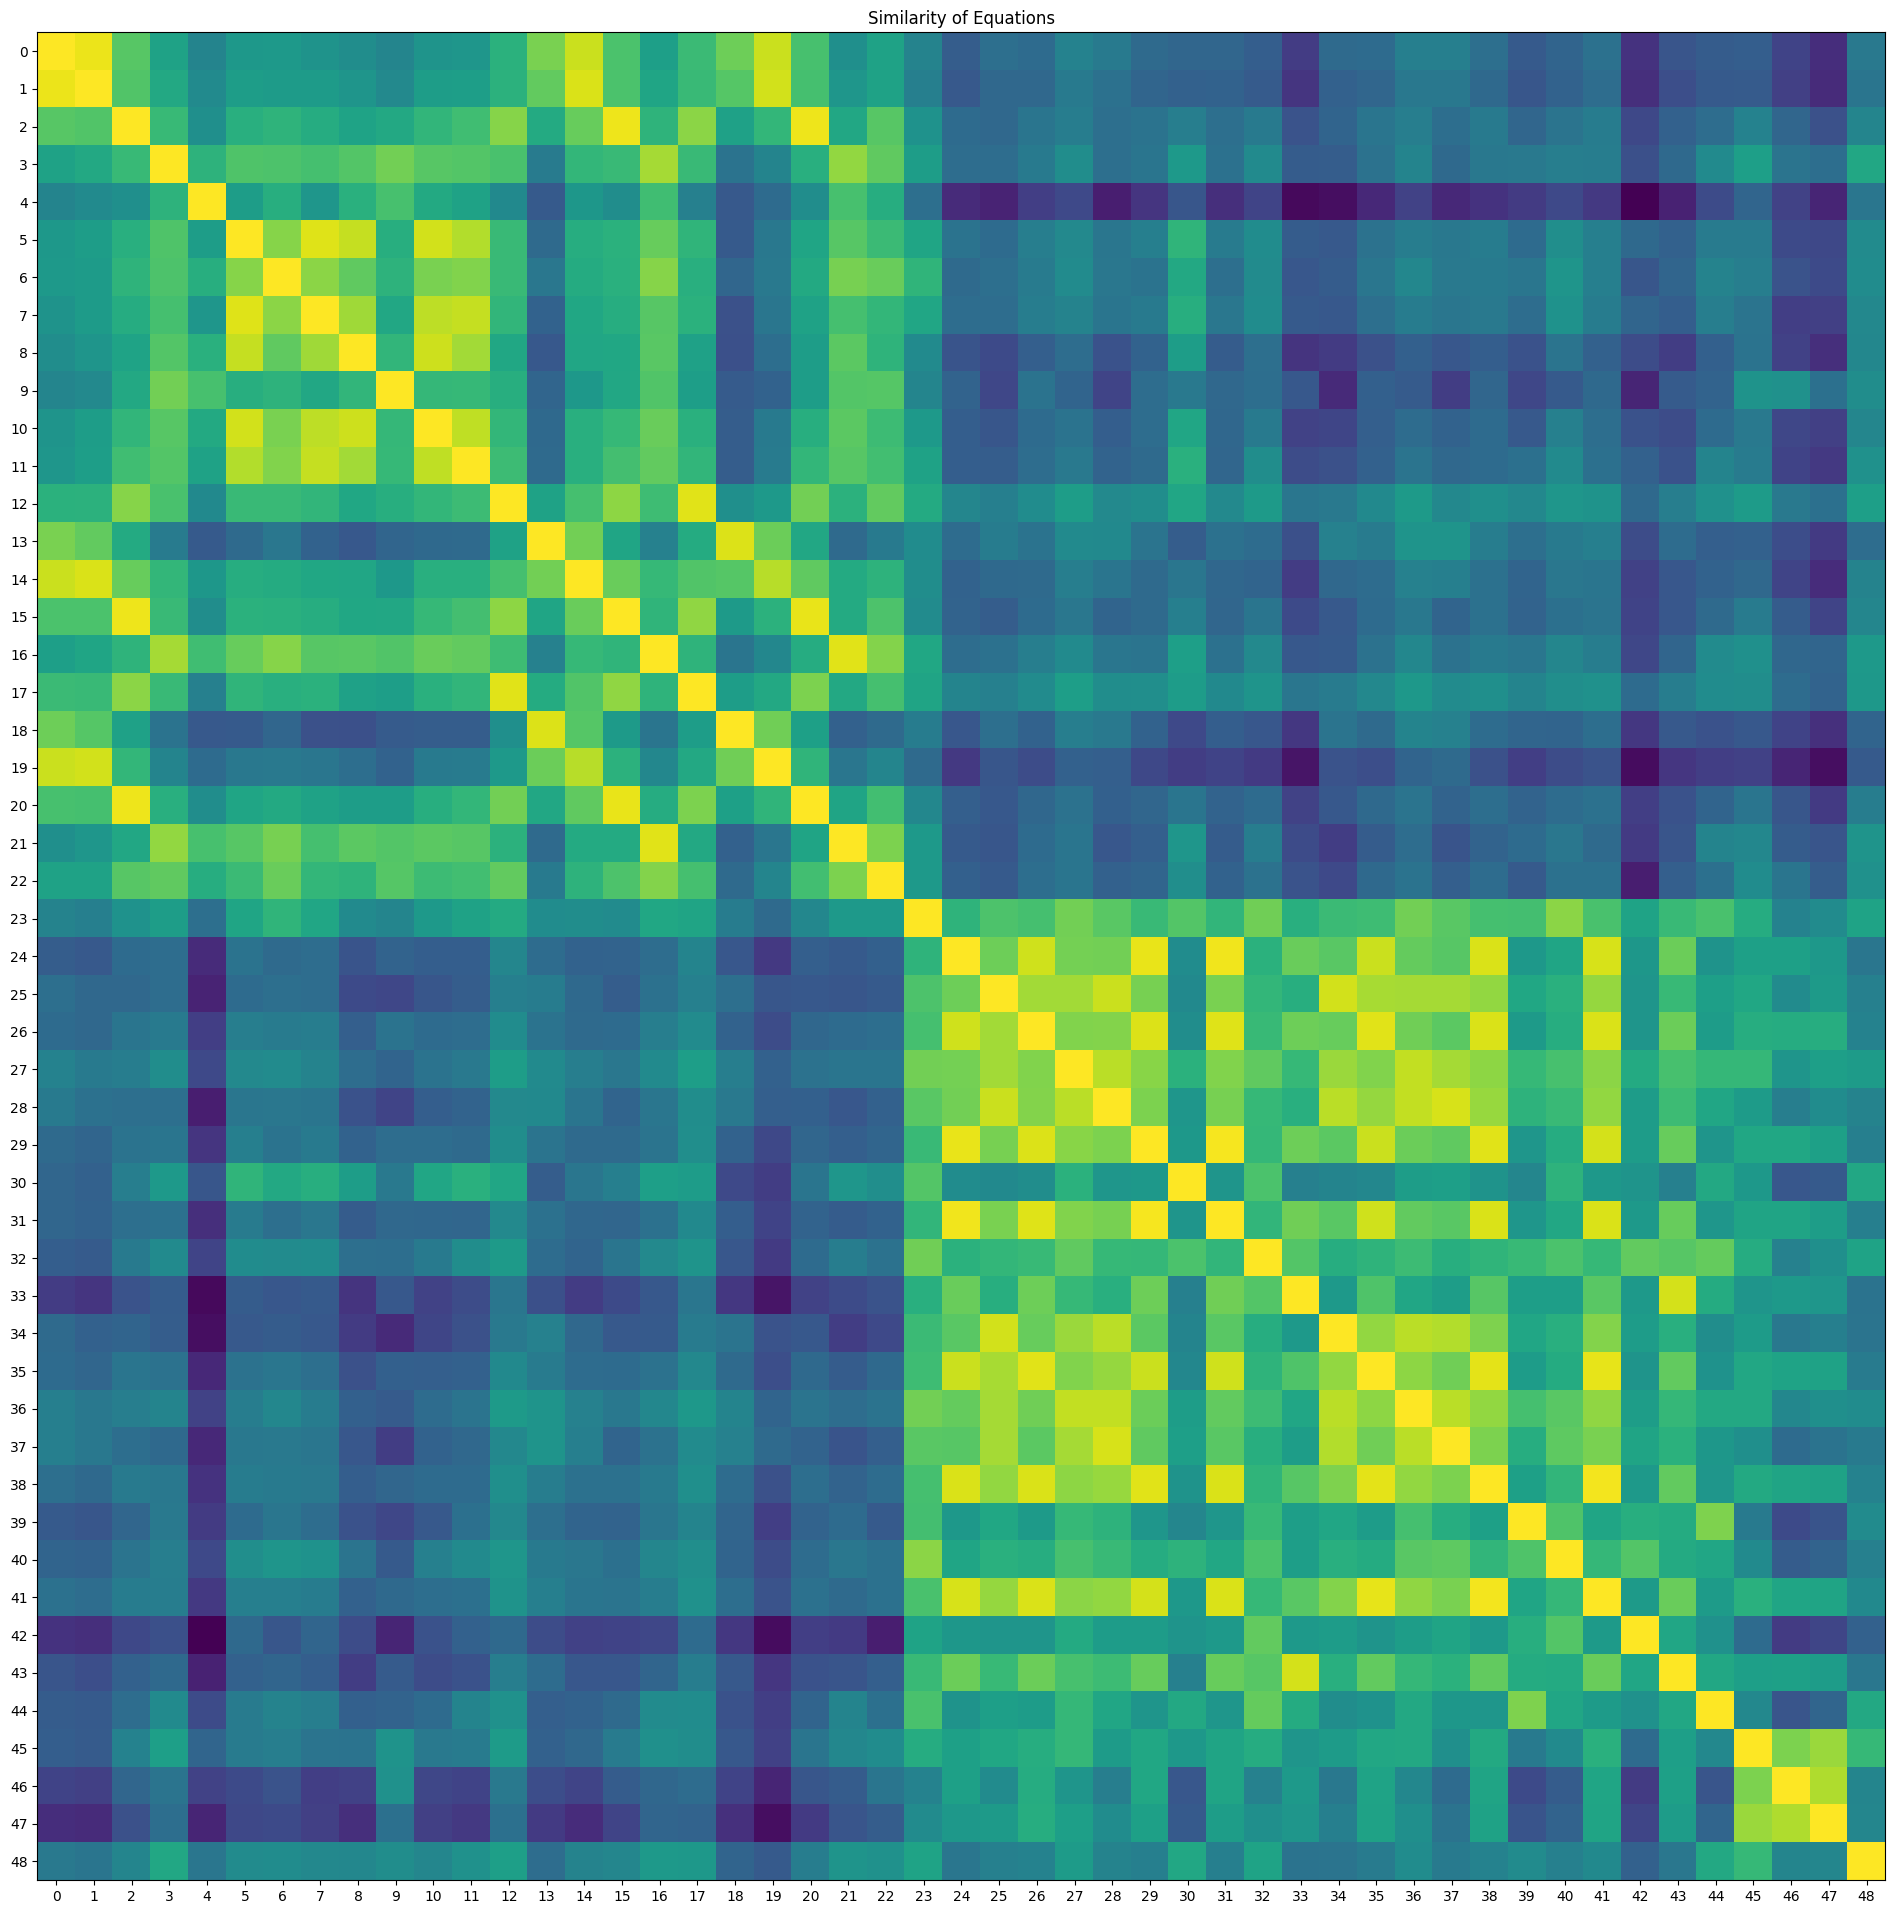

In [60]:
plt.figure(figsize=(24,24))
plt.xticks(range(eq_sim.shape[0]))
plt.yticks(range(eq_sim.shape[0]))
plt.imshow(eq_sim)
plt.title("Similarity of Equations")

Text(0.5, 1.0, 'Similarity of simplified Equations')

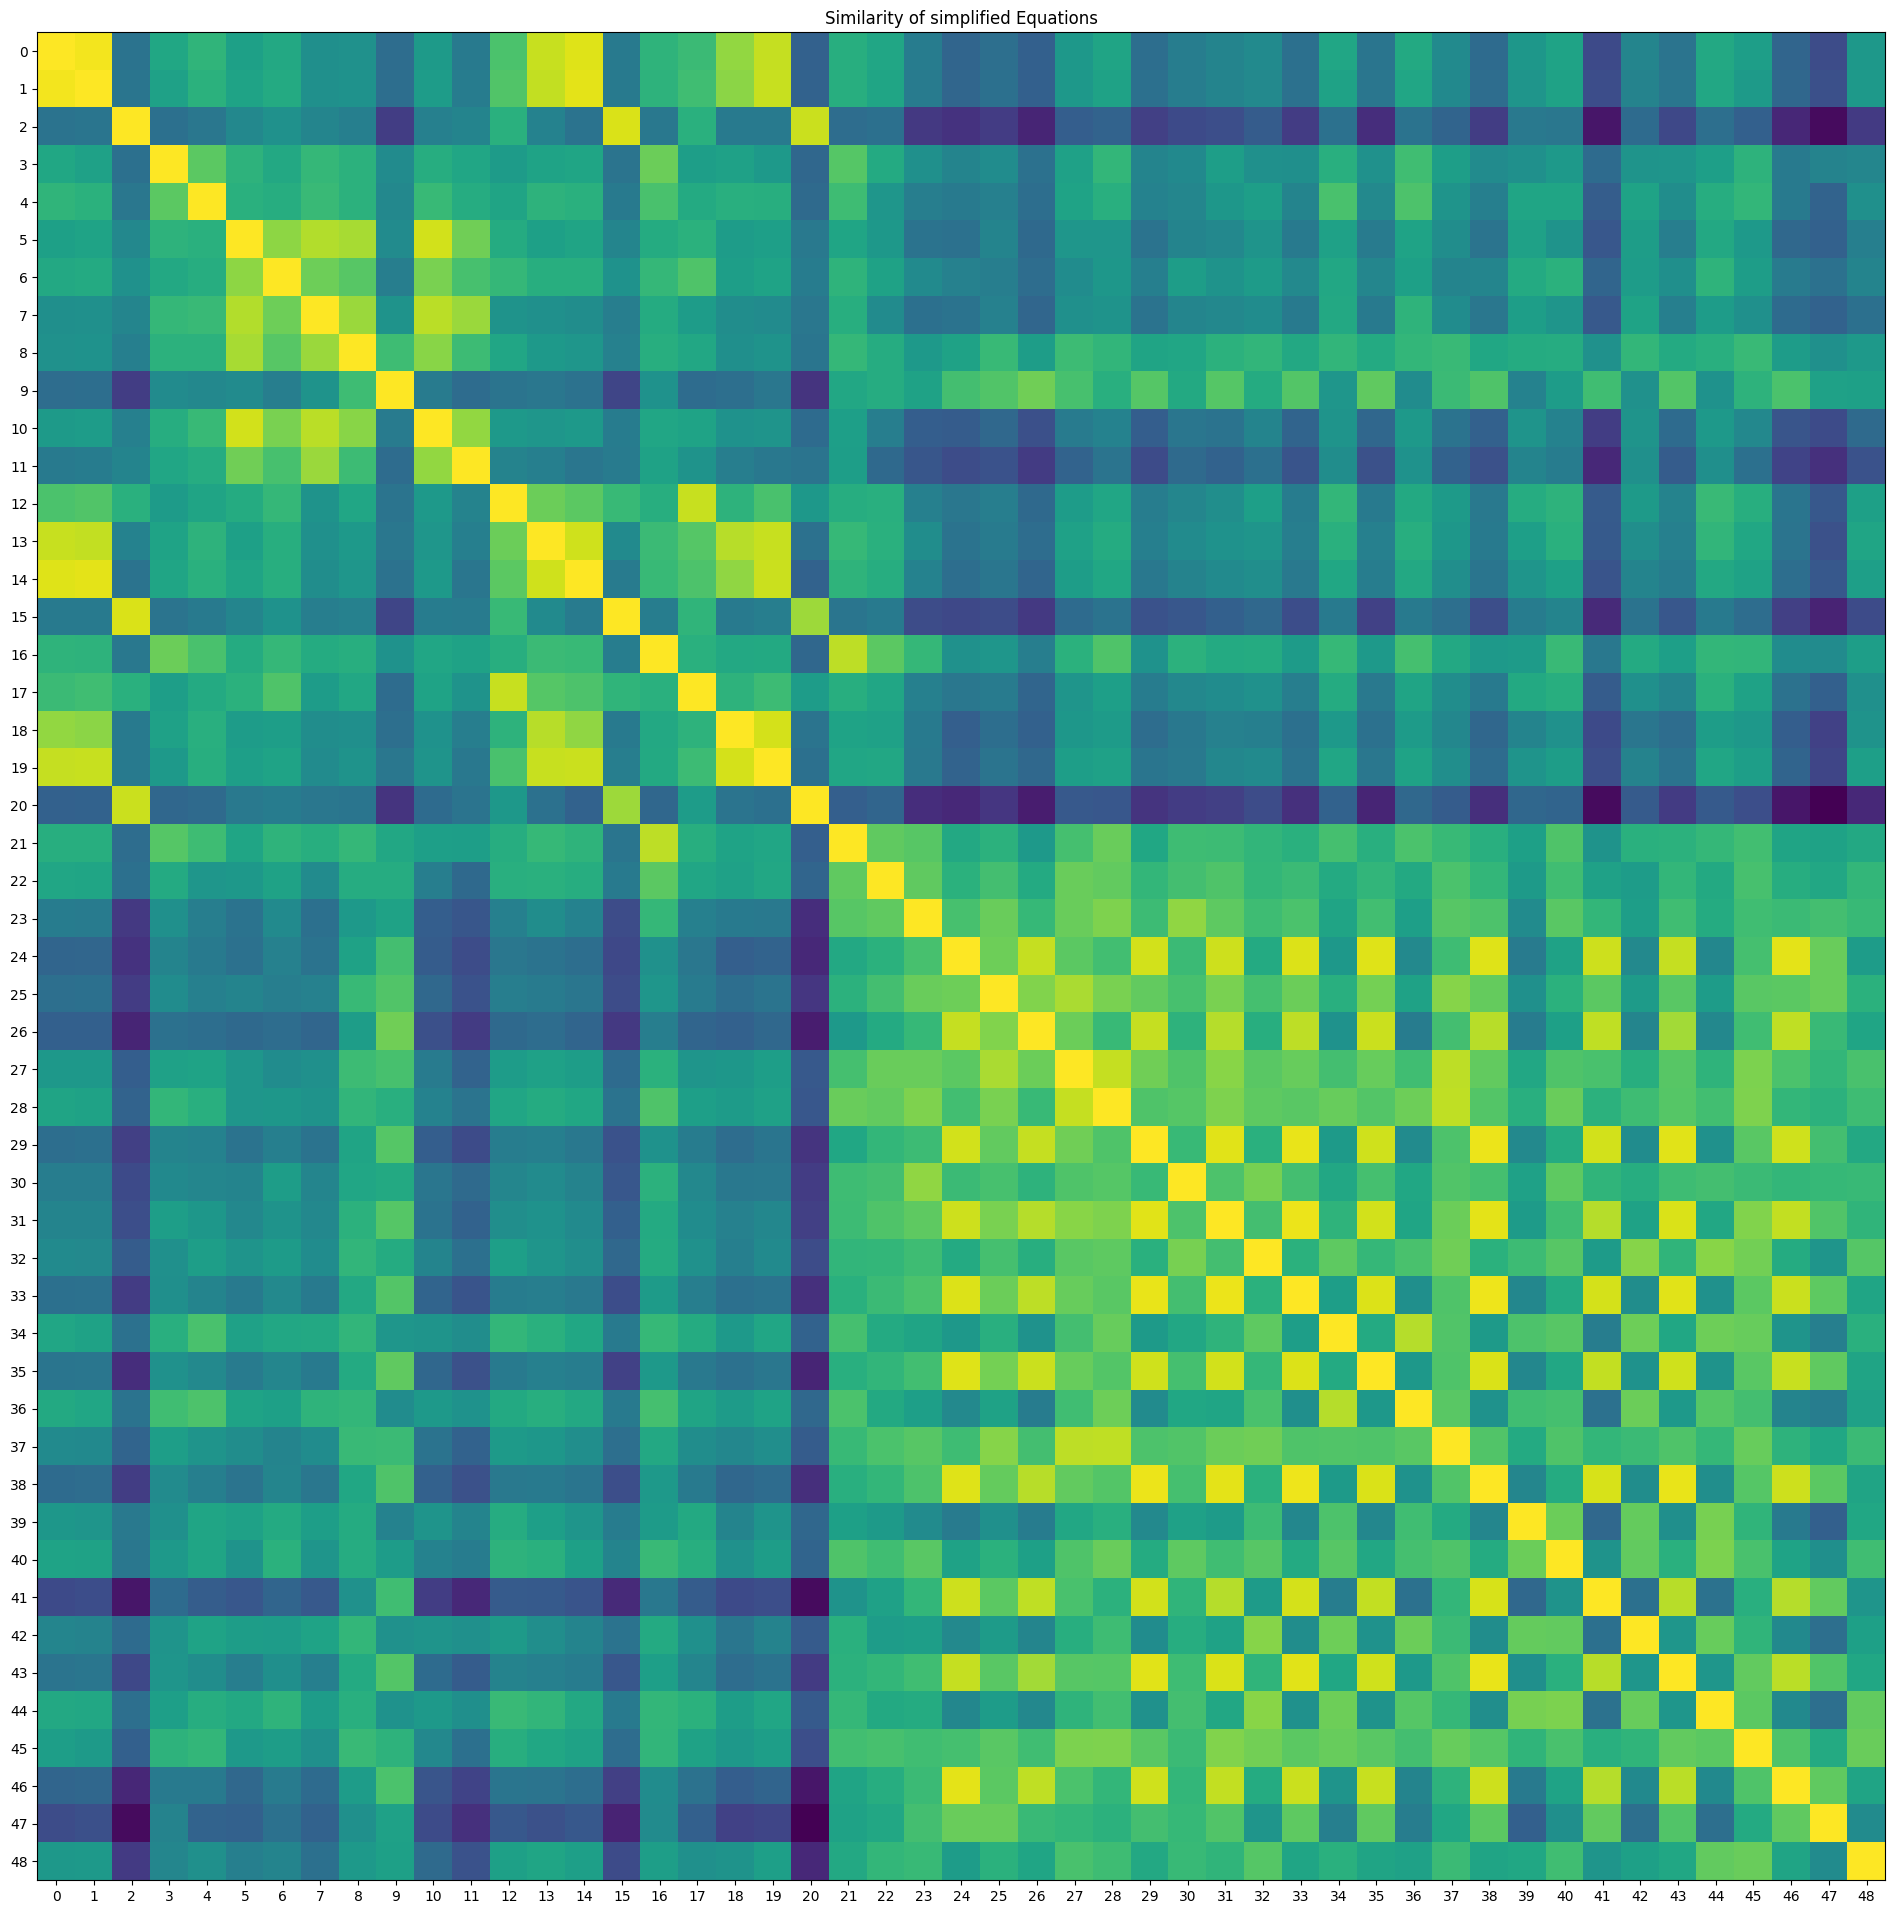

In [61]:
plt.figure(figsize=(24,24))
plt.xticks(range(eq_sim.shape[0]))
plt.yticks(range(eq_sim.shape[0]))
plt.imshow(s_eq_sim)
plt.title("Similarity of simplified Equations")

Text(0.5, 1.0, 'Similarity of Descriptions')

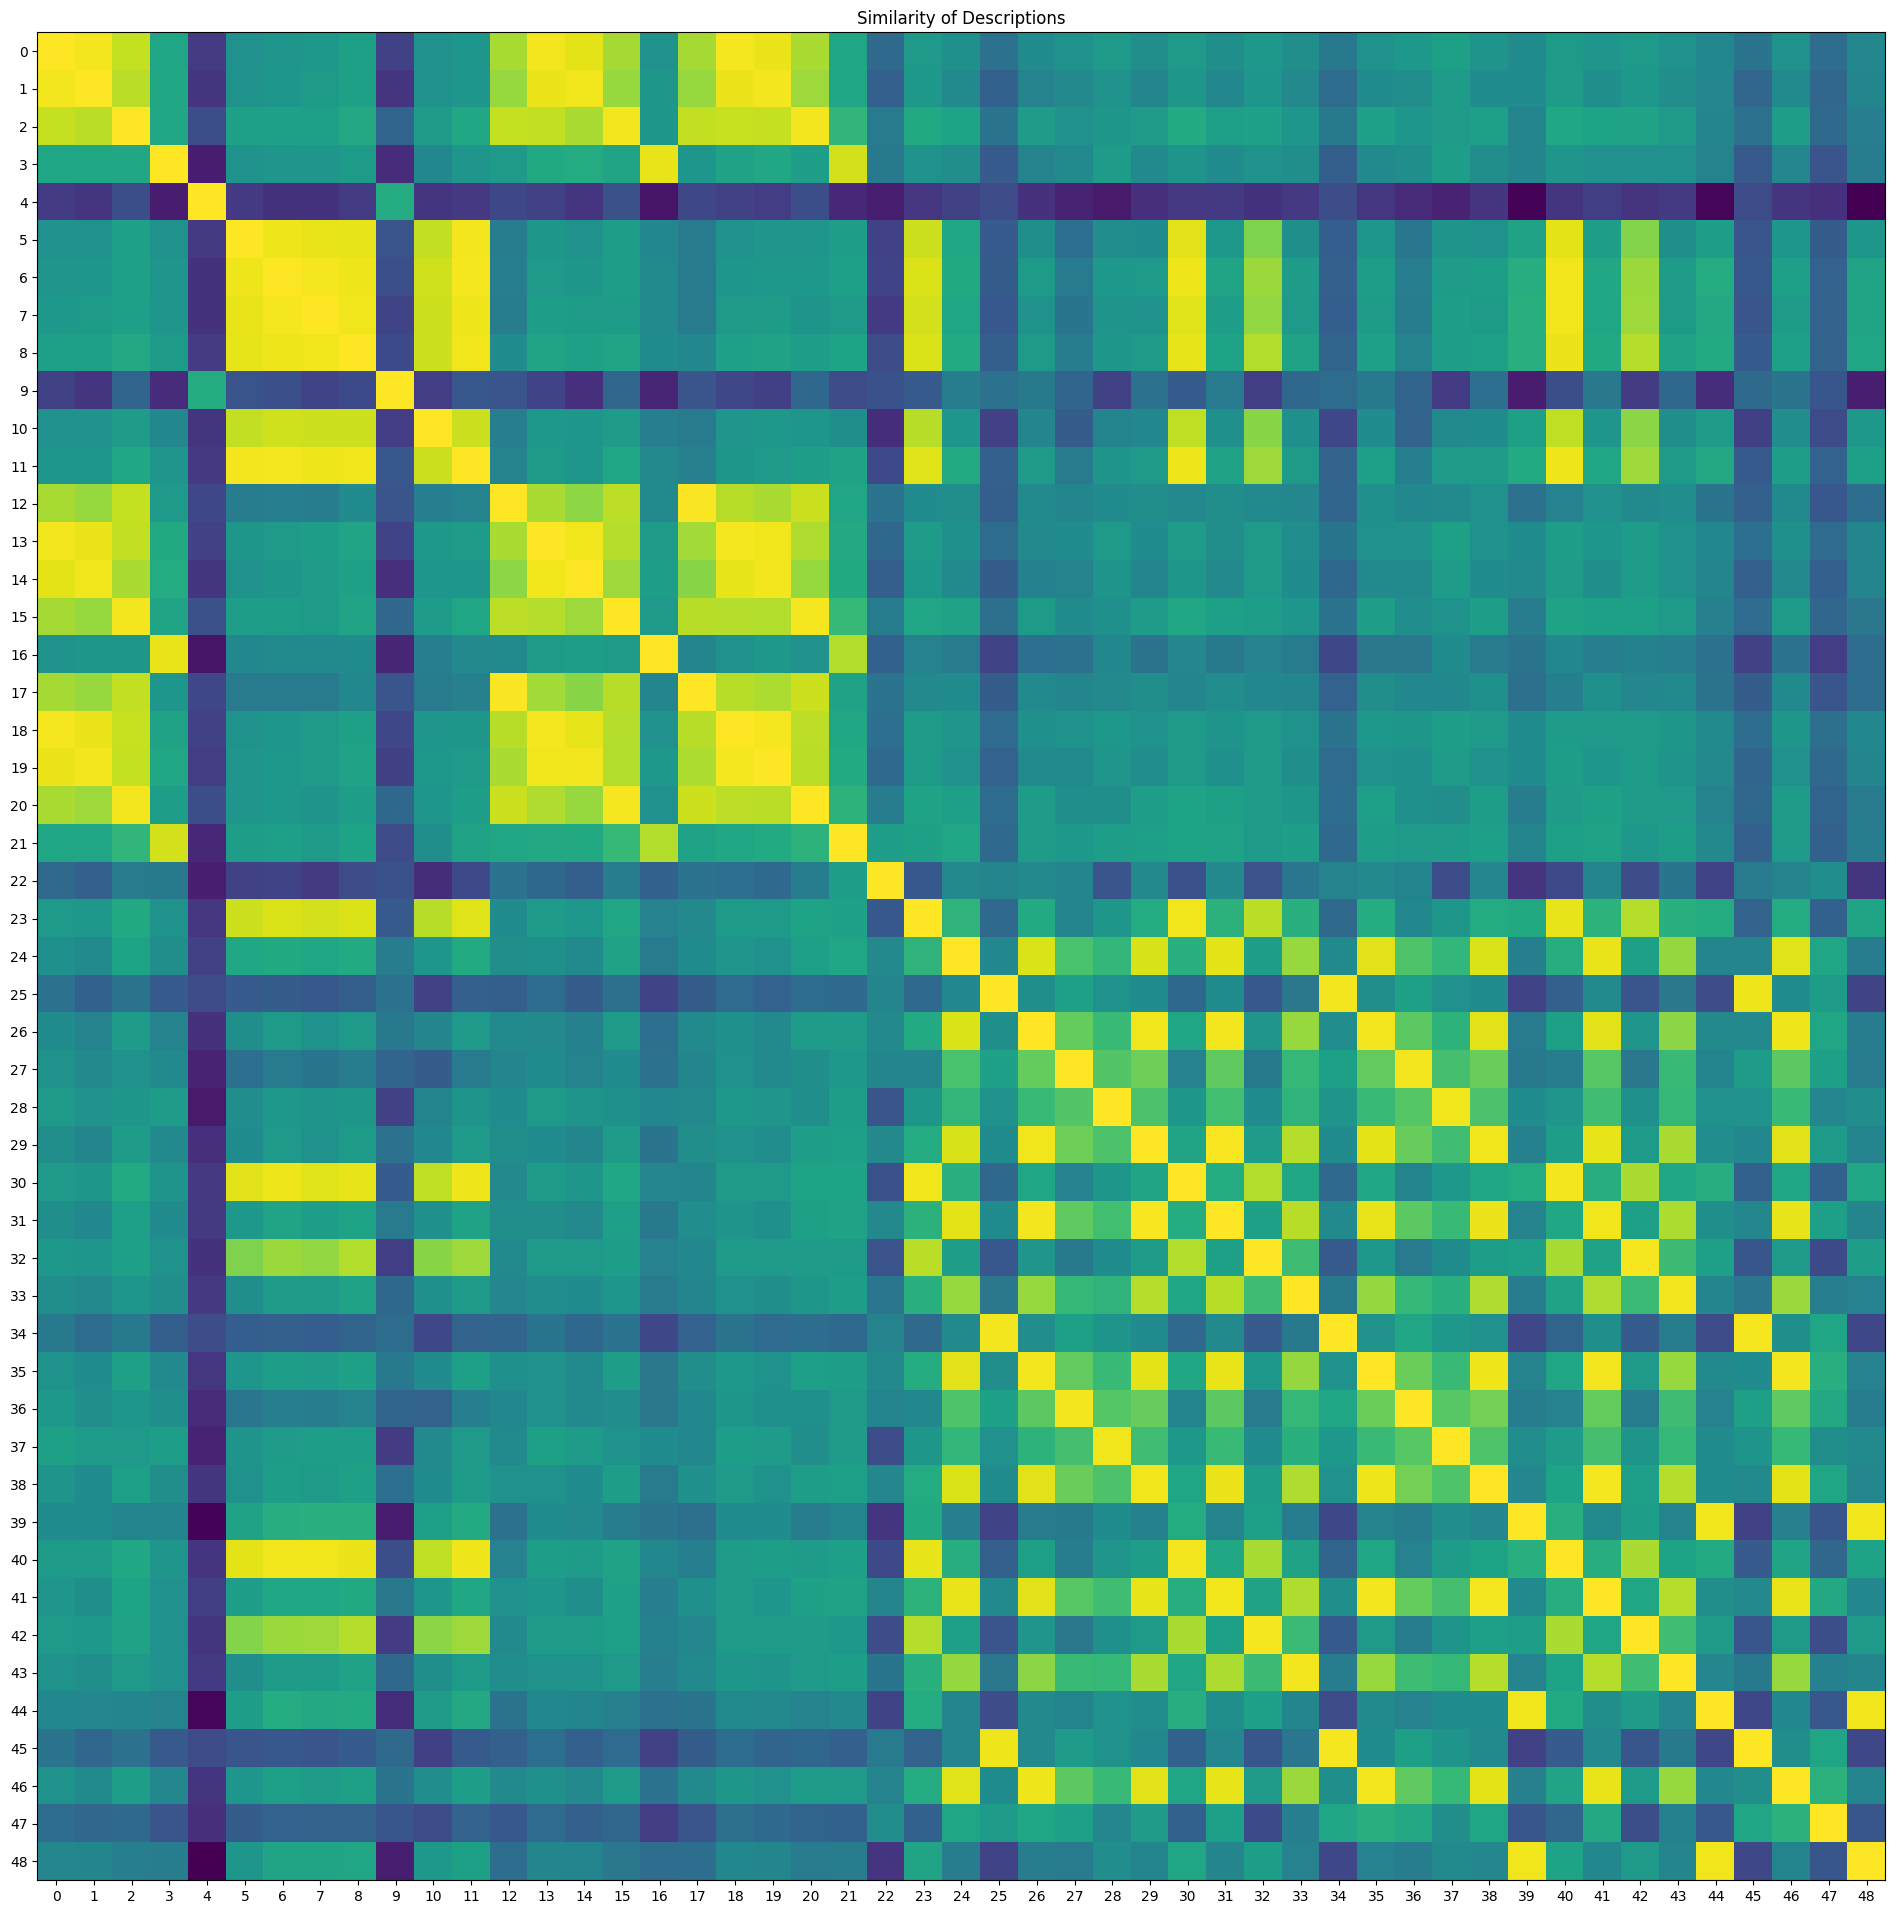

In [77]:
plt.figure(figsize=(24,24))
plt.xticks(range(eq_sim.shape[0]))
plt.yticks(range(eq_sim.shape[0]))
plt.imshow(desc_sim)
plt.title("Similarity of Descriptions")

### Lets try some visualization to see if things cluster nicely - TSNE?

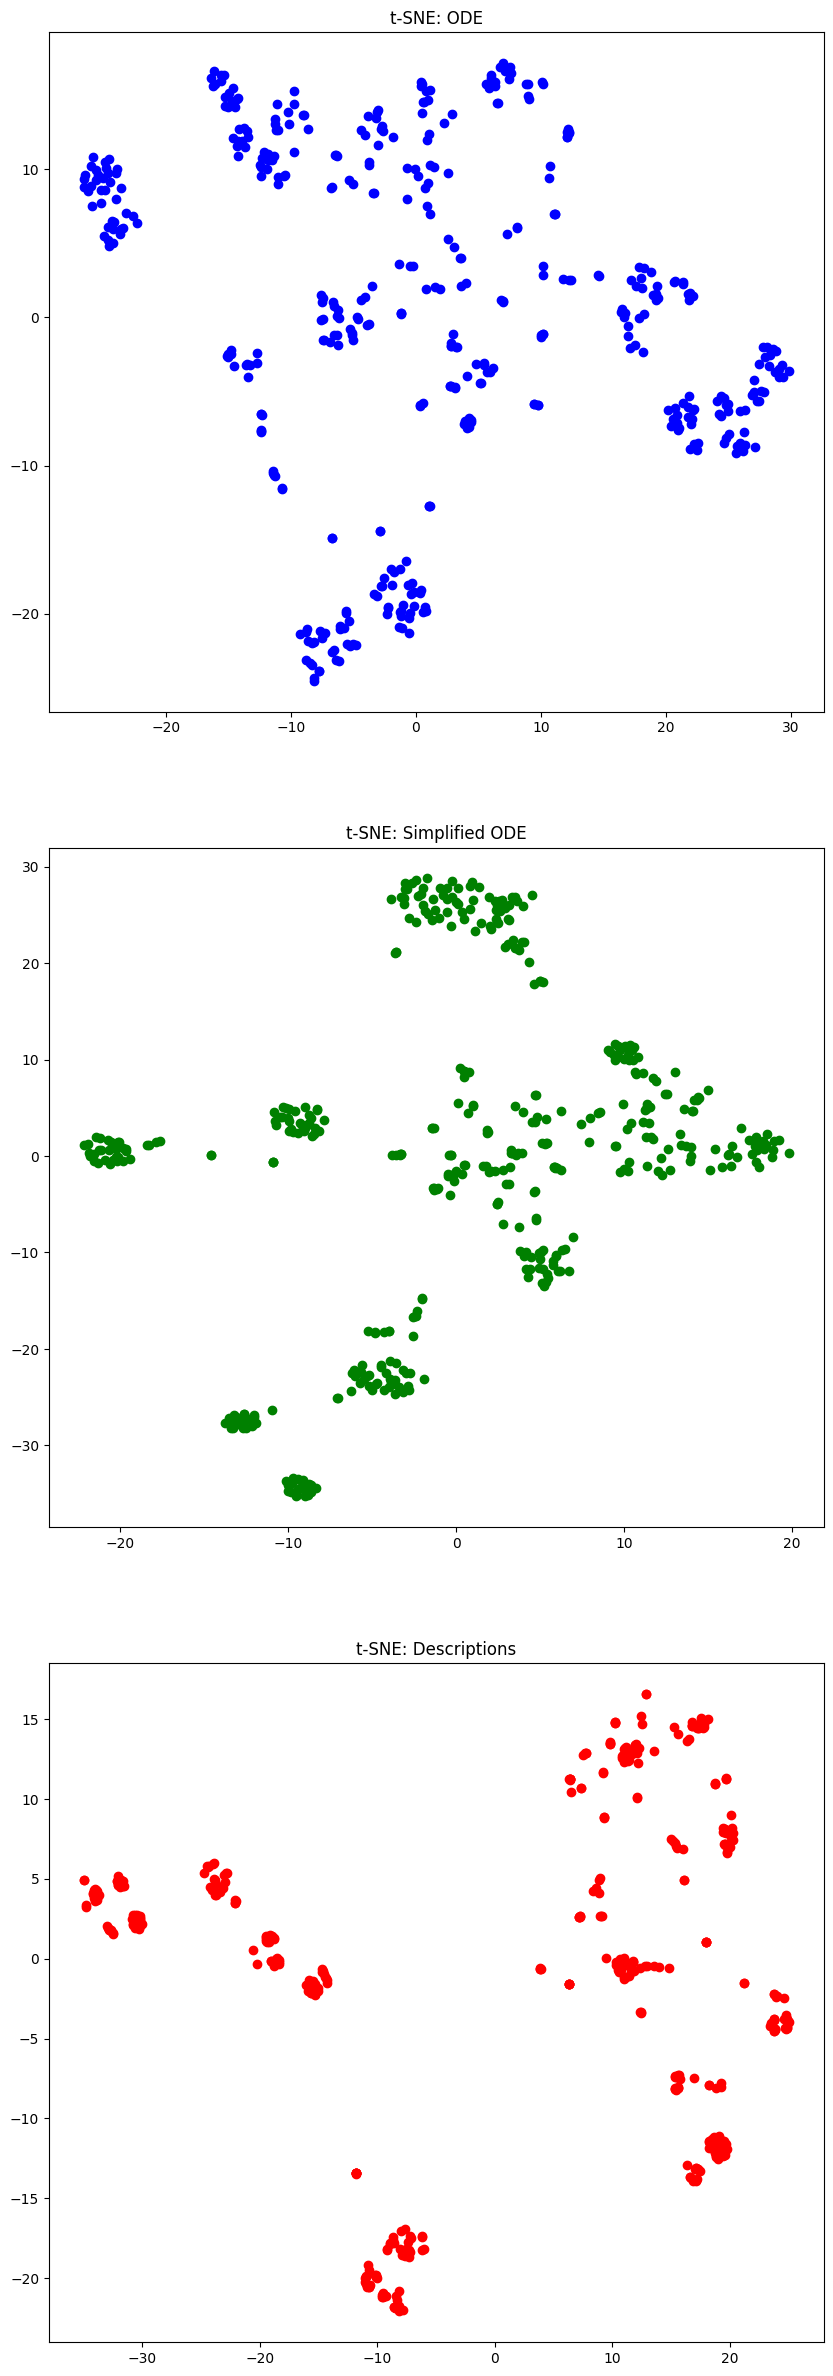

In [43]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne_A = TSNE(n_components=2, random_state=42, metric="cosine")
tsne_embeddings_A = tsne_A.fit_transform(eq_embs)
tsne_B = TSNE(n_components=2, random_state=42, metric="cosine")
tsne_embeddings_B = tsne_B.fit_transform(s_eq_embs)
tsne_C = TSNE(n_components=2, random_state=42, metric="cosine")
tsne_embeddings_C = tsne_C.fit_transform(desc_embs)
plt.figure(figsize=(10,30))
plt.subplot( 3,1, 1)
plt.scatter(tsne_embeddings_A[:, 0], tsne_embeddings_A[:, 1], color='blue', label='Equations')
plt.title("t-SNE: ODE")
plt.subplot( 3,1, 2)
plt.scatter(tsne_embeddings_B[:, 0], tsne_embeddings_B[:, 1], color='green', label='Simplified Equations')
plt.title("t-SNE: Simplified ODE")
plt.subplot( 3,1, 3)
plt.scatter(tsne_embeddings_C[:, 0], tsne_embeddings_C[:, 1], color='red', label='Descriptions')
plt.title("t-SNE: Descriptions")

plt.show()


### Are clusters based on  equations good predictors of description clusters?

In [78]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing

from sklearn.neighbors import NearestNeighbors
n_clusters = 5  
kmeans_A = KMeans(n_clusters=n_clusters, random_state=42).fit(preprocessing.normalize(eq_embs))
kmeans_B = KMeans(n_clusters=n_clusters, random_state=42).fit(preprocessing.normalize(desc_embs))

labels_A = kmeans_A.labels_
labels_B = kmeans_B.labels_
nn_model = NearestNeighbors(n_neighbors=1, metric='cosine')
nn_model.fit(desc_embs)
correct_matches = 0
for i, embedding_A in enumerate(eq_embs):
    distance, index = nn_model.kneighbors([embedding_A], return_distance=True)
    if labels_A[i] == labels_B[index[0][0]]:
        correct_matches += 1

accuracy = correct_matches / len(eq_embs)
print(f"Cross-modal cluster matching accuracy: {accuracy * 100:.2f}%")

Cross-modal cluster matching accuracy: 22.54%


### PCA now

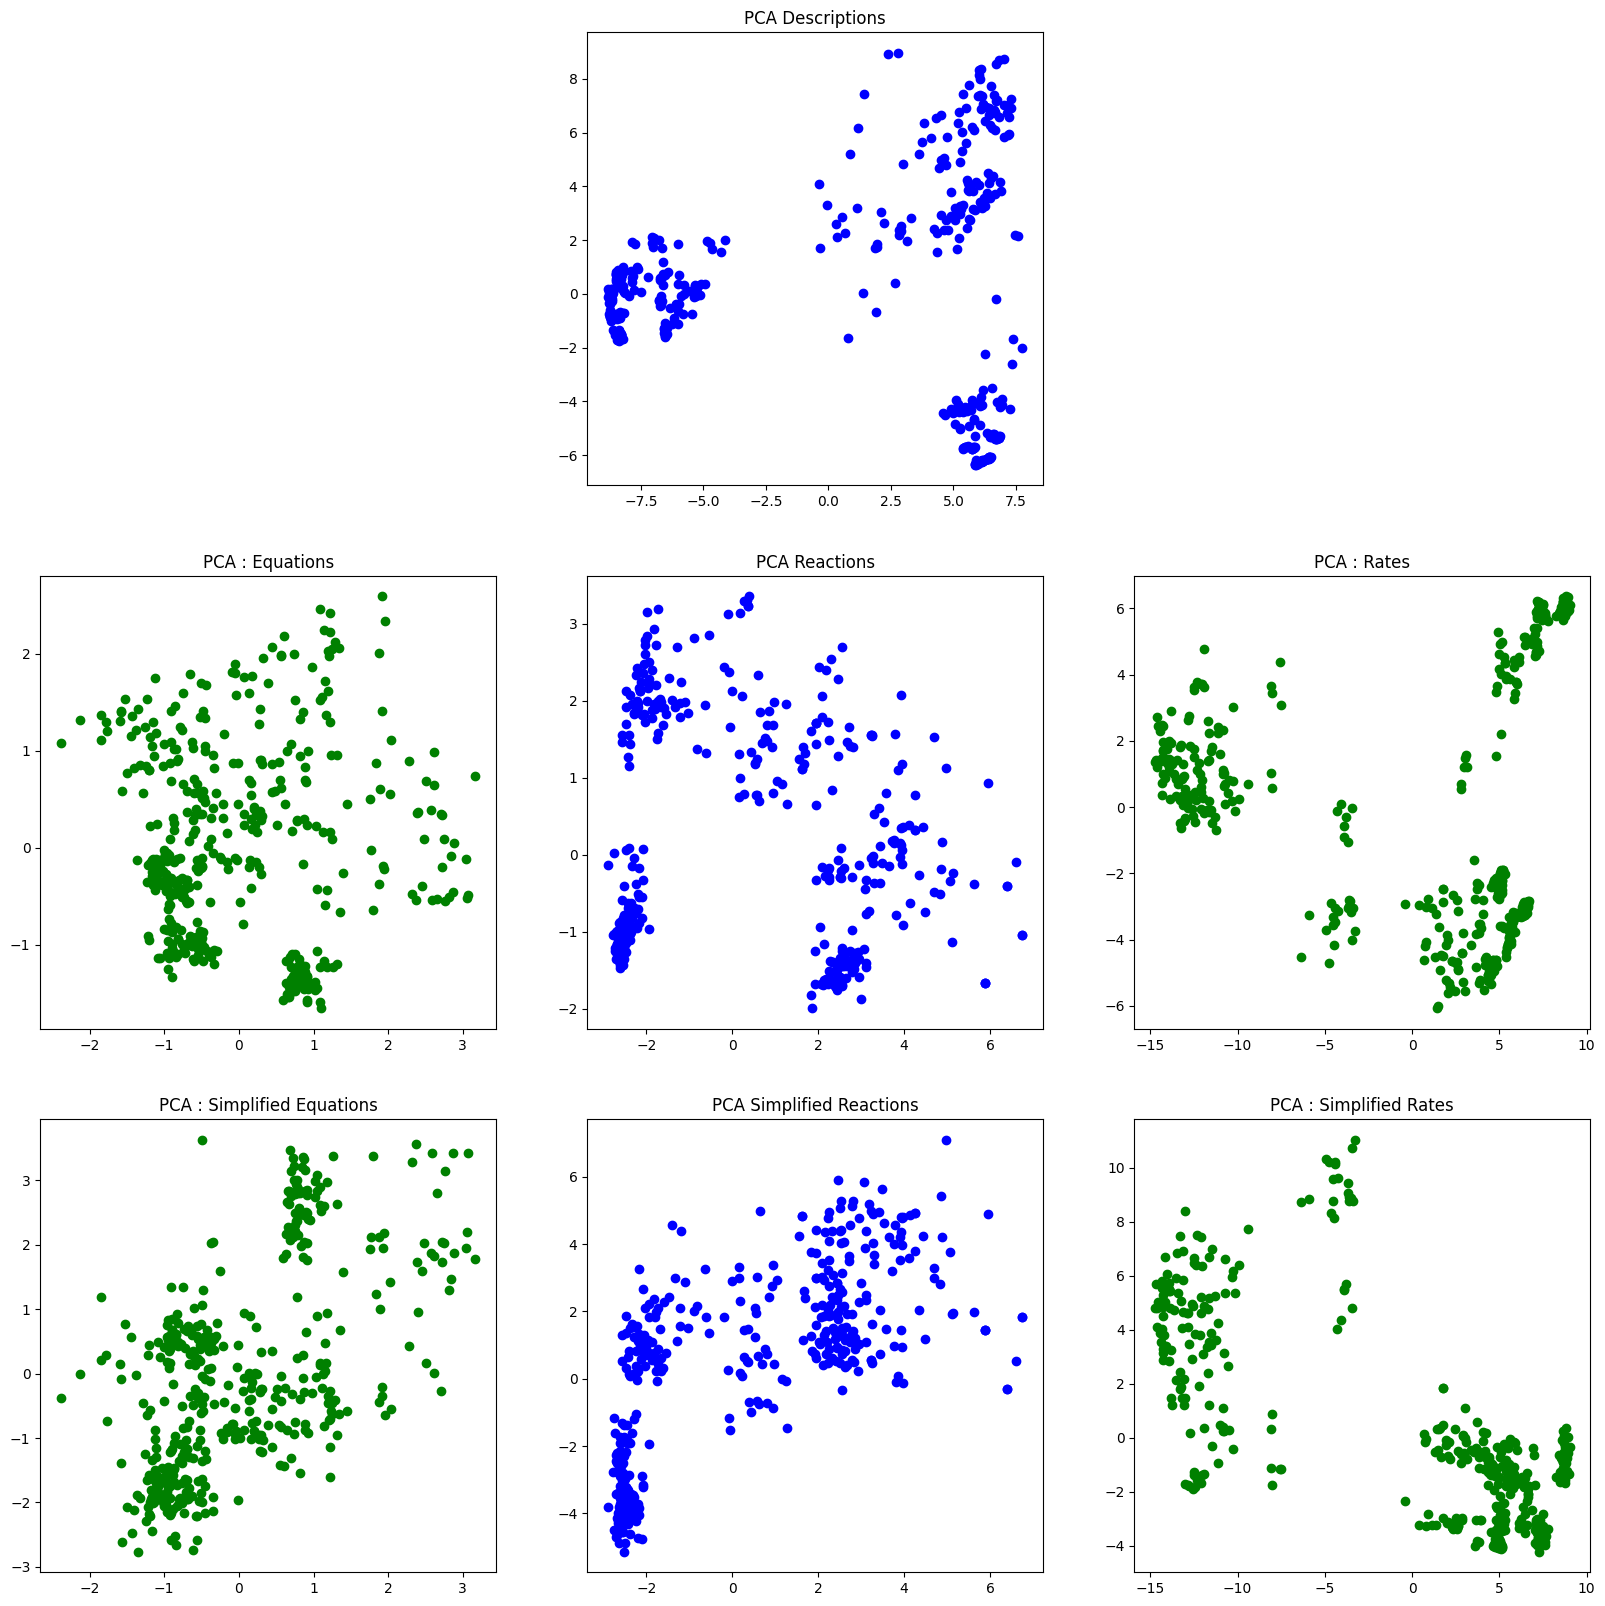

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
eq_red = pca.fit_transform(eq_embs)
desc_red = pca.fit_transform(desc_embs)
rcn_red = pca.fit_transform(rcn_embs)
rate_red = pca.fit_transform(rate_embs)
s_eq_red = pca.fit_transform(s_eq_embs)
s_rcn_red = pca.fit_transform(s_rcn_embs)
s_rate_red = pca.fit_transform(s_rate_embs)
plt.figure(figsize=(20,20))
plt.subplot(3, 3, 2)
plt.scatter(desc_red[:, 0], desc_red[:, 1], color='blue', label='Descriptions')
plt.title("PCA Descriptions")
plt.subplot(3, 3, 4)
plt.scatter(eq_red[:, 0], eq_red[:, 1], color='green', label='Equations')
plt.title("PCA : Equations")
plt.subplot(3, 3, 5)
plt.scatter(rcn_red[:, 0], rcn_red[:, 1], color='blue', label='Reactions')
plt.title("PCA Reactions")
plt.subplot(3, 3, 6)
plt.scatter(rate_red[:, 0], rate_red[:, 1], color='green', label='Rates')
plt.title("PCA : Rates")
plt.subplot(3, 3, 7)
plt.scatter(eq_red[:, 0], s_eq_red[:, 1], color='green', label='Equations')
plt.title("PCA : Simplified Equations")
plt.subplot(3, 3, 8)
plt.scatter(rcn_red[:, 0], s_rcn_red[:, 1], color='blue', label='Reactions')
plt.title("PCA Simplified Reactions")
plt.subplot(3, 3, 9)
plt.scatter(rate_red[:, 0], s_rate_red[:, 1], color='green', label='Rates')
plt.title("PCA : Simplified Rates")
plt.show()

### How much mutual information is present here?

In [52]:
from sklearn.mixture import GaussianMixture

def do_gmm_stuff(X, nc, text):
    gmm = GaussianMixture(n_components=nc, covariance_type='full', random_state=0)
    gmm.fit(X)
    labels = gmm.predict(X)
    plt.figure(figsize=(10,10))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
    
    plt.title(f"GMM Clustering : {text}")
    plt.xlabel("PCA Feat 1")
    plt.ylabel("PCA Feat 2")
    plt.show()
    return labels


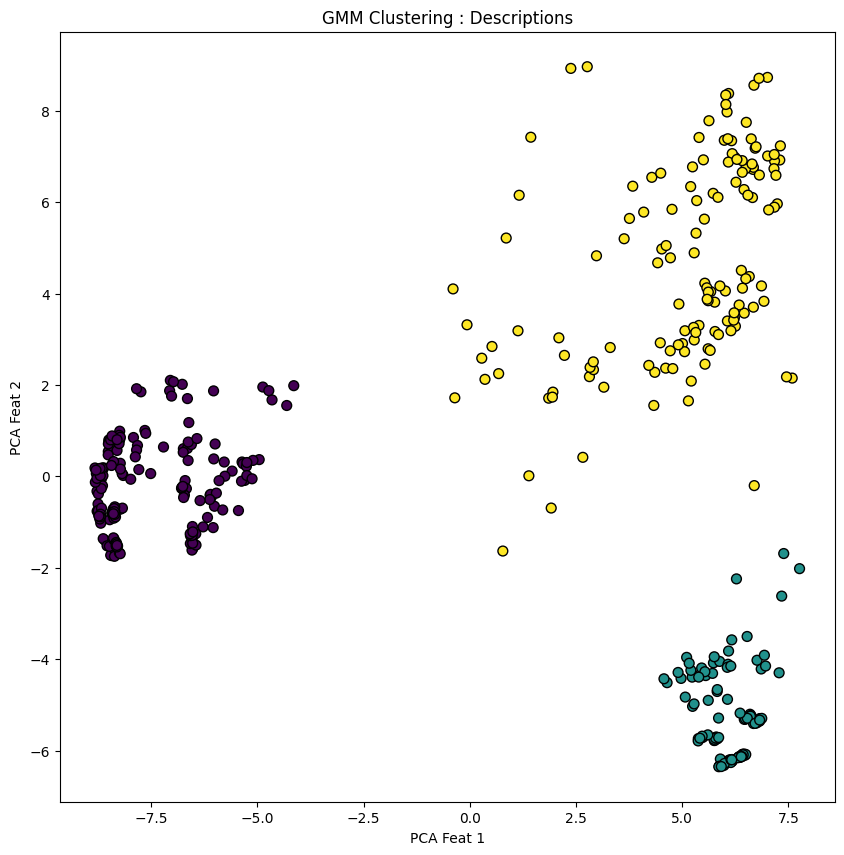

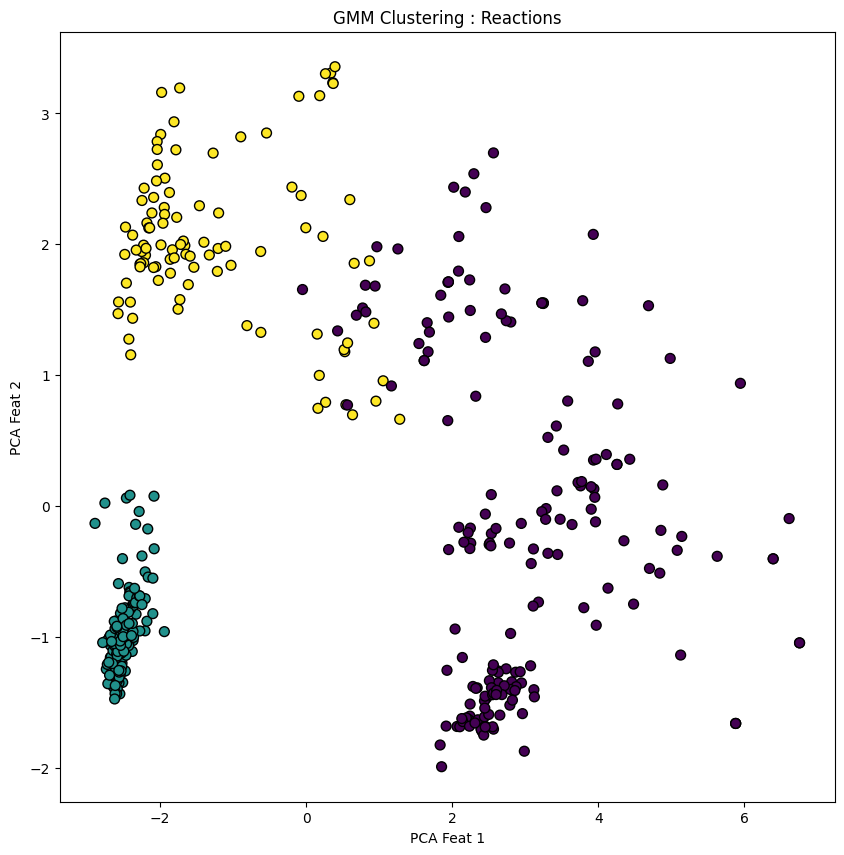

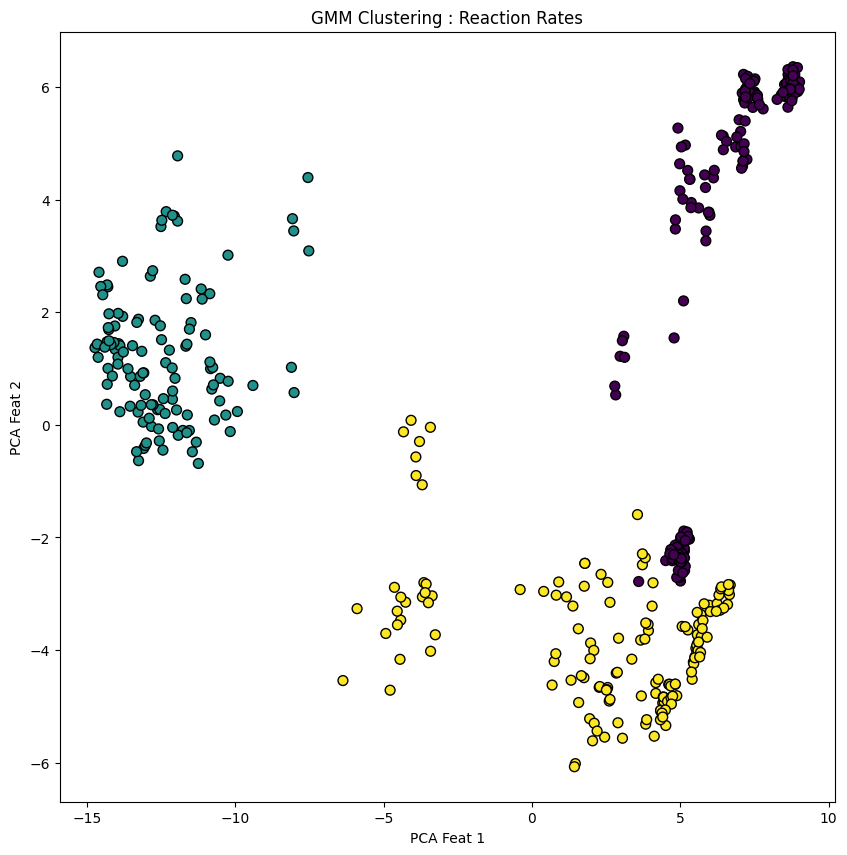

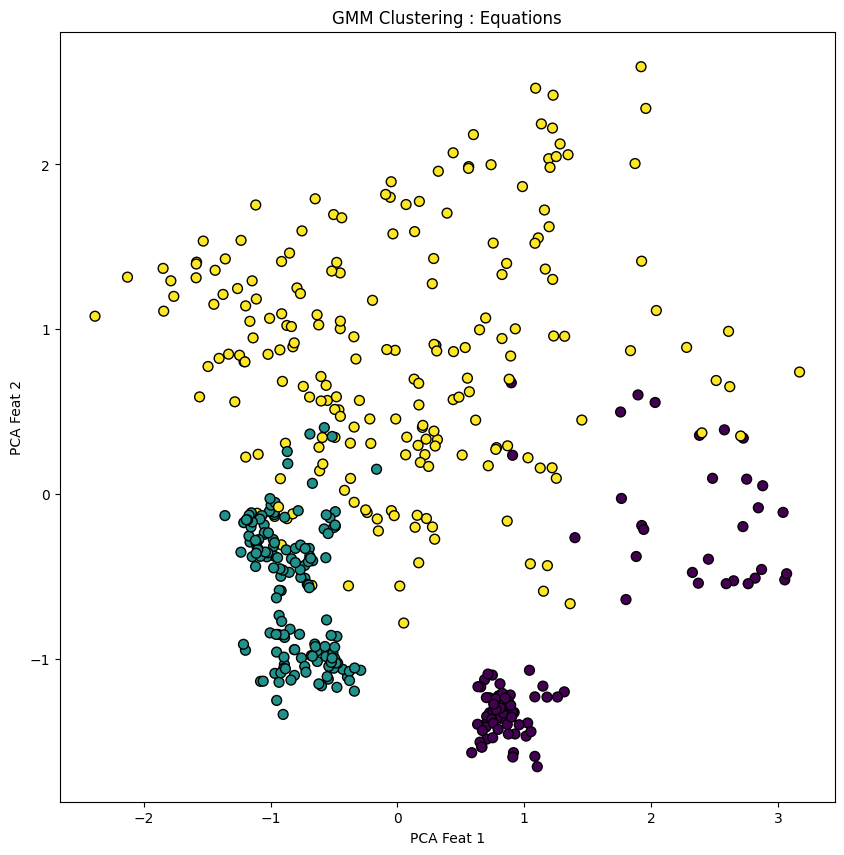

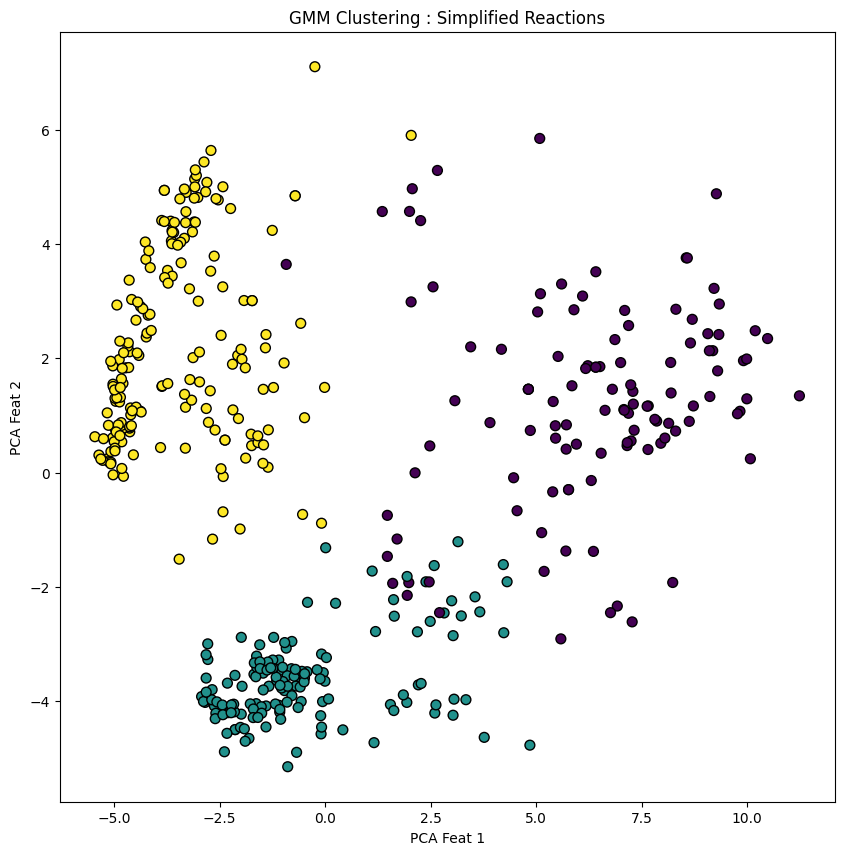

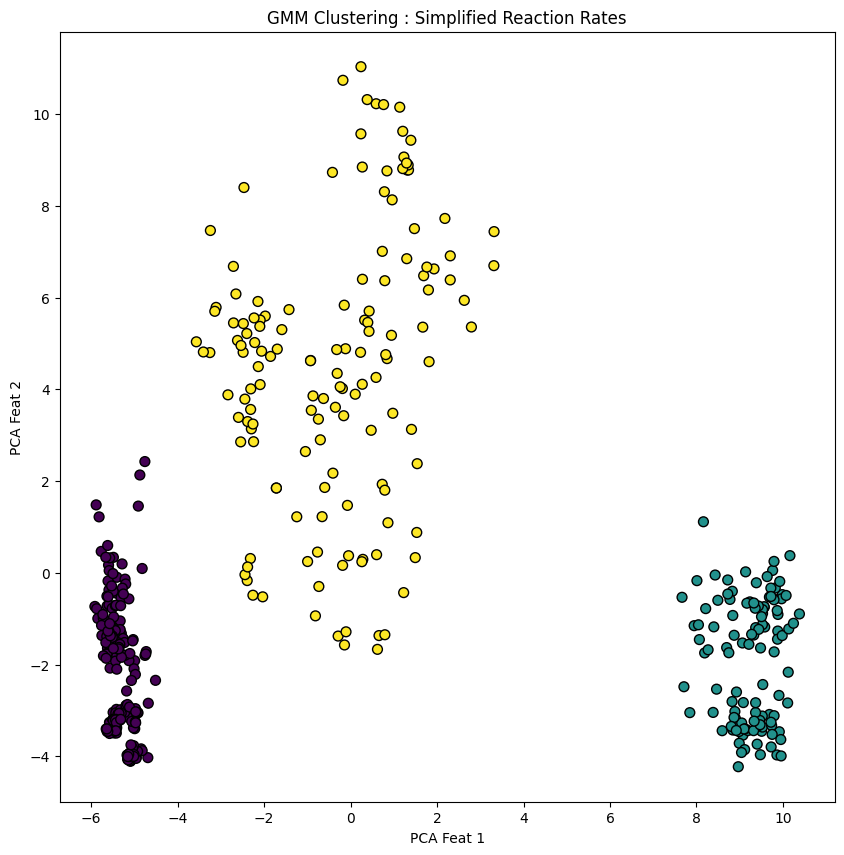

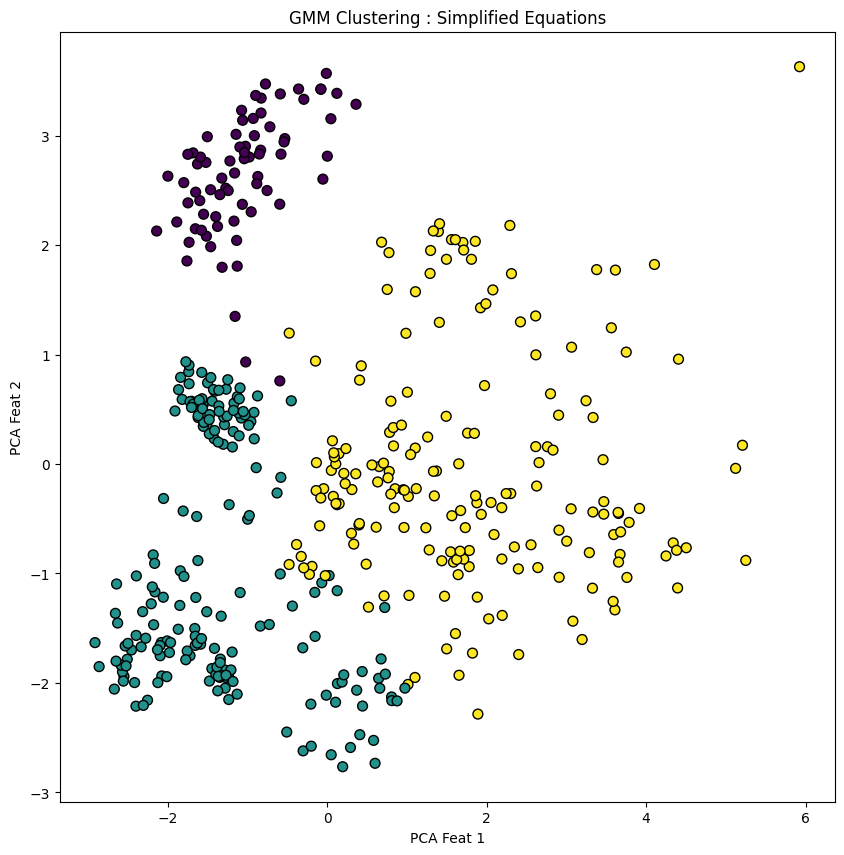

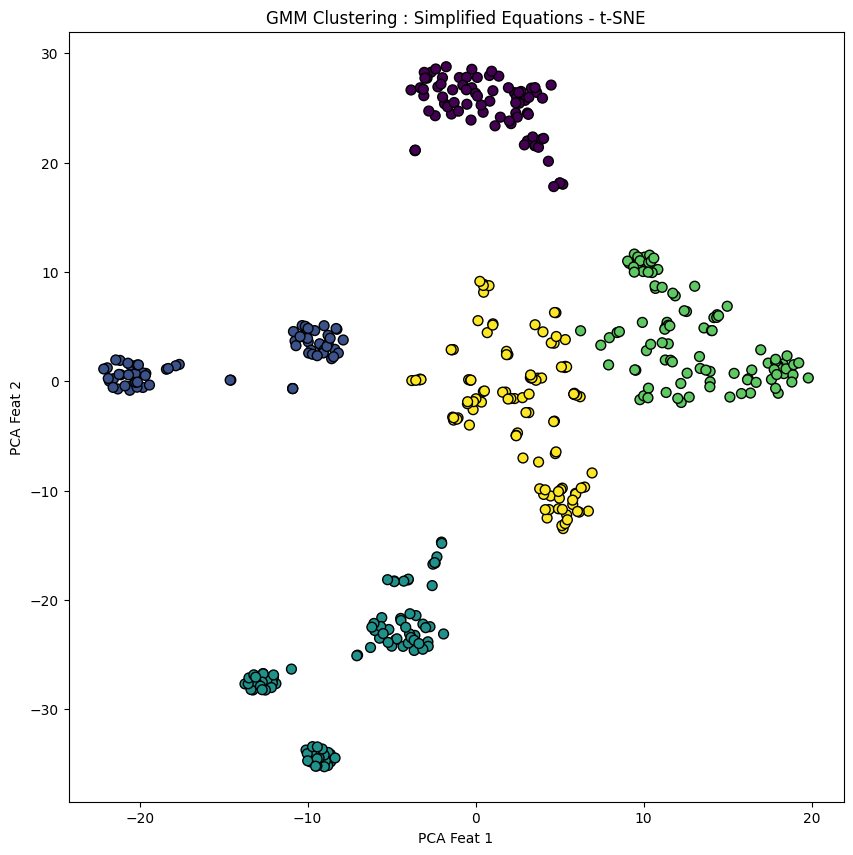

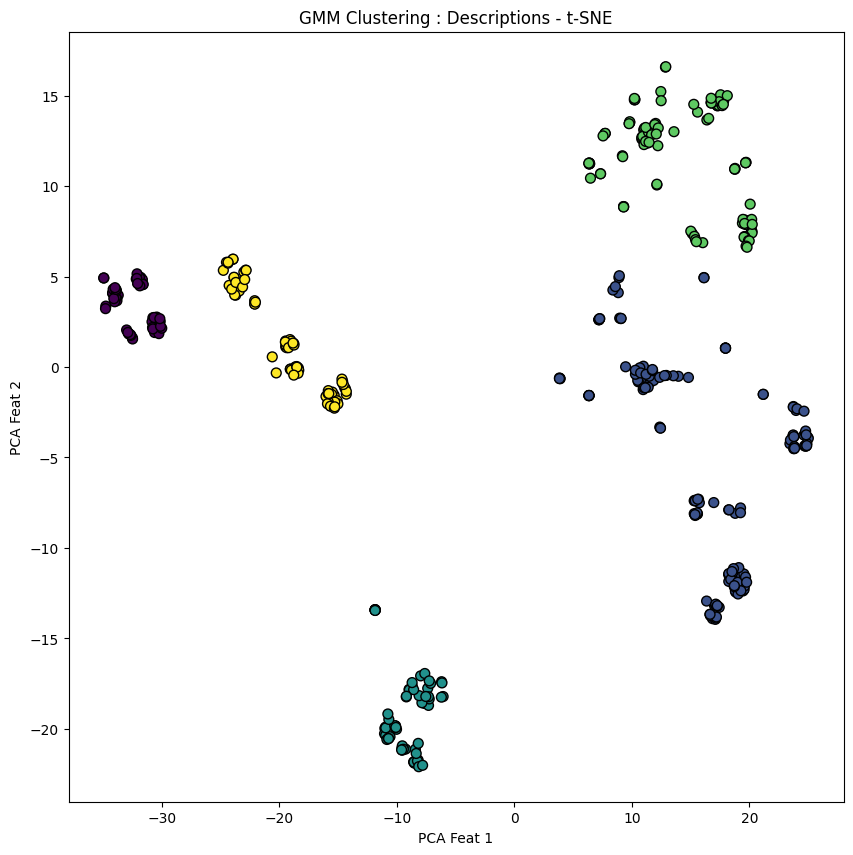

In [56]:
desc_labels =do_gmm_stuff(desc_red,3, "Descriptions")
rcn_labels =do_gmm_stuff(rcn_red,3, "Reactions")
rate_labels =do_gmm_stuff(rate_red,3, "Reaction Rates")
eqn_labels =do_gmm_stuff(eq_red,3, "Equations")
s_rcn_labels =do_gmm_stuff(s_rcn_red,3, "Simplified Reactions")
s_rate_labels =do_gmm_stuff(s_rate_red,3, "Simplified Reaction Rates")
s_eqn_labels =do_gmm_stuff(s_eq_red,3, "Simplified Equations")
s_tsne_ode_labels = do_gmm_stuff(tsne_embeddings_B,5,"Simplified Equations - t-SNE")

s_tsne_desc_labels = do_gmm_stuff(tsne_embeddings_C,5,"Descriptions - t-SNE")


In [72]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score

metrics = {}
metrics["Reactions vs Desc"] = normalized_mutual_info_score(rcn_labels, desc_labels)
metrics["Reaction Rates vs Desc"]  = normalized_mutual_info_score(rate_labels, desc_labels)
metrics["ODE vs Desc"]  = normalized_mutual_info_score(eqn_labels, desc_labels)
metrics["Simplified Reactions vs Desc"] = normalized_mutual_info_score(s_rcn_labels, desc_labels)
metrics["Simplified Reaction Rates vs Desc"]  = normalized_mutual_info_score(s_rate_labels, desc_labels)
metrics["Simplified ODE vs Desc"]  = normalized_mutual_info_score(s_eqn_labels, desc_labels)
metrics["Simplified ODE vs Desc (tSNE)"]  = normalized_mutual_info_score(s_tsne_ode_labels, s_tsne_desc_labels)
pd.DataFrame(metrics, index=["Normalized Mutual Information Score"]).T

,Normalized Mutual Information Score
Reactions vs Desc,0.206880
Reaction Rates vs Desc,0.460889
ODE vs Desc,0.423313
Simplified Reactions vs Desc,0.237263
Simplified Reaction Rates vs Desc,0.933370
Simplified ODE vs Desc,0.392180
Simplified ODE vs Desc (tSNE),0.456384


### What now?
- We see that pretrained embeddings already capture similarity in information between the ODEs and the Natural Language Description.
- We did not simplify the description because this involves lemmatization and stemming using the supplied supplementary information, which was beyond the scope for the hackathon. This will most likely improve the NMI score between simplified reaction/rate/ODE and the description.
- Alignment between the two embeddings will help us build a generative model for a copilot like experience.
- Therefore the next step would be to align the two embeddings using a CLIP like self-supervised learning step. This would require far more examples than the 448 equations that we currently have.